In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
from pandas import read_csv

In [3]:
series = read_csv('AirPassengers.csv', header=0, index_col=0,
parse_dates=True).squeeze()

In [4]:
type(series)

pandas.core.series.Series

In [5]:
len(series)

144

In [7]:
series.describe()

count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: #Passengers, dtype: float64

# Problem Description

The problem is to predict the number of people fly every month of the year   . The dataset provides Monthly Number of people fliy 
 from 1949  to 1960, or 11 years of data. The values are without  units because they represent humans ,There are no null records present.

In [8]:
series.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [9]:
series.tail()

Month
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, dtype: int64

## Defining a Validation Dataset.

The dataset is not current. This means that we cannot easily collect updated data to validate
the model. Therefore, we will pretend that it is 1958 and withhold the last 10 years of data
from analysis and model selection. This final decade of data will be used to validate the final
model. The code below will load the dataset as a Pandas Series and split into two, one for
model development (dataset.csv) and the other for validation (validation.csv).

In [10]:
# separate out a validation dataset
split_point = len(series) - 24
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 120, Validation 24


In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def walk_forward_validation(train, test):
    history = [x for x in train]
    predictions = list()

    for i in range(len(test)):
        # predict
        yhat = history[-1]
        predictions.append(yhat)

        # observation
        obs = test[i]
        history.append(obs)
        print('> Predicted=%.3f, Expected=%.3f' % (yhat, obs))

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, predictions))
    print('RMSE: %.3f' % rmse)

    return rmse

# Persistence

The first step before getting bogged down in data analysis and modeling is to establish a baseline
of performance. This will provide both a template for evaluating models using the proposed
test harness and a performance measure by which all more elaborate predictive models can be
compared. The baseline prediction for time series forecasting is called the naive forecast, or
persistence. This is where the observation from the previous time step is used as the prediction
for the observation at the next time step. We can plug this directly into the test harness defined
in the previous section. The complete code listing is provided below.

In [90]:
def evaluate_persistence_model(train, test):
    # Walk-forward validation
    history = [x for x in train]
    predictions = list()

    for i in range(len(test)):
        # Predict
        yhat = history[-1]
        predictions.append(yhat)
        
        # Observation
        obs = test[i]
        history.append(obs)
        
        print('> Predicted=%.3f, Expected=%.3f' % (yhat, obs))

    # Report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    print('RMSE: %.3f' % rmse)

    return rmse

# Data Analysis

## Summary Statistics 

In [13]:
# summary statistics of time series
from pandas import read_csv
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()

In [14]:
series.describe()

count    120.000000
mean     245.908333
std       94.942087
min      104.000000
25%      170.750000
50%      233.500000
75%      313.500000
max      505.000000
Name: 1, dtype: float64

## Line Plot

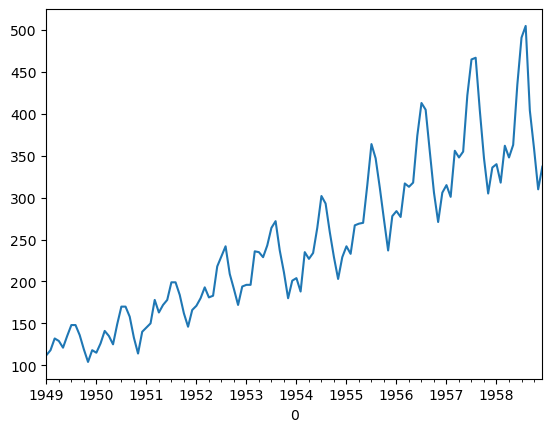

In [15]:
from matplotlib import pyplot
series.plot()
pyplot.show()

## Density Plot

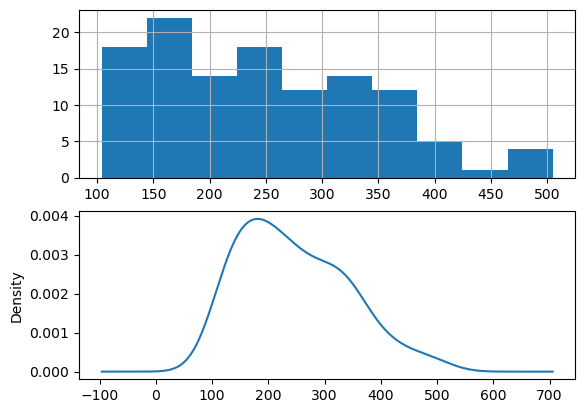

In [16]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

## Box and Whisker Plots 

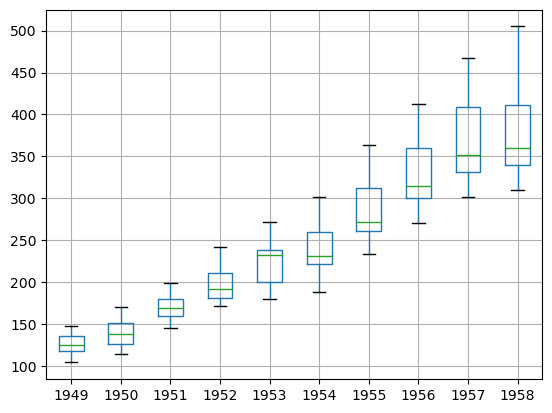

In [17]:
from pandas import DataFrame
from pandas import Grouper
groups = series['1949':'1958'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
 years[name.year] = group.values
years.boxplot()
pyplot.show()

# ARIMA Models

## Manually Configured ARIMA

In [18]:
# statistical test for the stationarity of the time series
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller

In [19]:
# create a differenced time series
def difference(dataset):
 diff = list()
 for i in range(1, len(dataset)):
  value = dataset[i] - dataset[i - 1]
  diff.append(value)
 return Series(diff)

In [20]:
X = series.values

In [21]:
# difference data
stationary = difference(X)
stationary.index = series.index[1:]

In [22]:
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.164143
p-value: 0.219516
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


In [23]:
stationary = difference(difference(X))

In [24]:
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.947364
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


In [25]:
# save
stationary.to_csv('stationary.csv', header=False)

In [26]:
stationary

0        8
1      -17
2       -5
3       22
4       -1
      ... 
113    -42
114   -115
115     56
116     -4
117     76
Length: 118, dtype: int64

In [27]:
# ACF and PACF plots of the time series
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

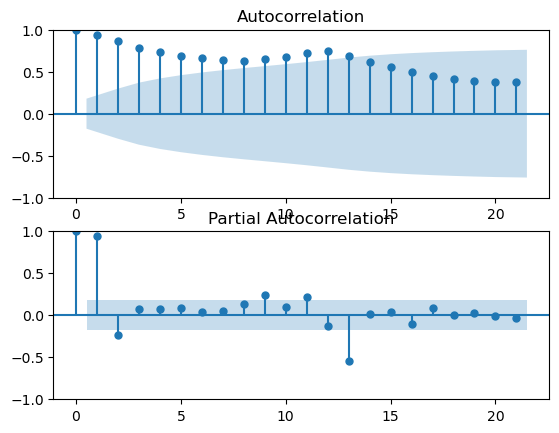

In [28]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(series,ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series,ax=pyplot.gca())
pyplot.show()

In [29]:
# evaluate manually configured ARIMA model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

In [30]:
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [31]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(13,2,6))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=217.869, Expected=204.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=207.187, Expected=188.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=223.627, Expected=235.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=238.439, Expected=227.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=232.650, Expected=234.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=240.593, Expected=264.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=281.779, Expected=302.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=307.327, Expected=293.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=265.311, Expected=259.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=235.450, Expected=229.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=205.945, Expected=203.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=221.054, Expected=229.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=229.635, Expected=242.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=223.920, Expected=233.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=262.715, Expected=267.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=263.942, Expected=269.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=267.209, Expected=270.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=302.036, Expected=315.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=337.767, Expected=364.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=353.190, Expected=347.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=307.543, Expected=312.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=282.930, Expected=274.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=248.339, Expected=237.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=259.019, Expected=278.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=286.326, Expected=284.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=276.523, Expected=277.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=296.658, Expected=317.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=322.421, Expected=313.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=312.368, Expected=318.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=361.740, Expected=374.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=413.268, Expected=413.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=395.442, Expected=405.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=367.042, Expected=355.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=318.840, Expected=306.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=276.159, Expected=271.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=308.821, Expected=306.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=318.181, Expected=315.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=306.612, Expected=301.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=337.091, Expected=356.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=352.230, Expected=348.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=356.107, Expected=355.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=408.355, Expected=422.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=452.564, Expected=465.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=453.472, Expected=467.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=418.962, Expected=404.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=351.376, Expected=347.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=316.797, Expected=305.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=338.000, Expected=336.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=347.529, Expected=340.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=329.490, Expected=318.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=369.398, Expected=362.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=360.076, Expected=348.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=361.938, Expected=363.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=432.911, Expected=435.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=481.026, Expected=491.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=490.413, Expected=505.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=449.333, Expected=404.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=349.809, Expected=359.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=320.473, Expected=310.000
>Predicted=341.562, Expected=337.000


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 12.476


# Grid Search ARIMA Hyperparameters

p: 0 to 16.
d: 0 to 5.
q: 0 to 12.

In [33]:
# grid search ARIMA parameters for time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [35]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg,best_score

In [36]:
# evaluate parameters
p_values = range(0,13)
d_values = range(0,3)
q_values = range(0,7)
warnings.filterwarnings("ignore")
best_cfg,best_score=evaluate_models(X, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=127.794
ARIMA(0, 0, 1) RMSE=69.142
ARIMA(0, 0, 2) RMSE=52.891
ARIMA(0, 0, 3) RMSE=41.186
ARIMA(0, 0, 4) RMSE=40.417
ARIMA(0, 0, 5) RMSE=37.829
ARIMA(0, 0, 6) RMSE=39.746
ARIMA(0, 1, 0) RMSE=36.627
ARIMA(0, 1, 1) RMSE=34.666
ARIMA(0, 1, 2) RMSE=35.178
ARIMA(0, 1, 3) RMSE=36.198
ARIMA(0, 1, 4) RMSE=31.428
ARIMA(0, 1, 5) RMSE=32.433
ARIMA(0, 1, 6) RMSE=32.791
ARIMA(0, 2, 0) RMSE=43.035
ARIMA(0, 2, 1) RMSE=36.758
ARIMA(0, 2, 2) RMSE=34.801
ARIMA(0, 2, 3) RMSE=35.387
ARIMA(0, 2, 4) RMSE=36.521
ARIMA(0, 2, 5) RMSE=31.178
ARIMA(0, 2, 6) RMSE=31.545
ARIMA(1, 0, 0) RMSE=37.069
ARIMA(1, 0, 1) RMSE=34.956
ARIMA(1, 0, 2) RMSE=35.411
ARIMA(1, 0, 3) RMSE=37.096
ARIMA(1, 0, 4) RMSE=32.073
ARIMA(1, 0, 5) RMSE=31.259
ARIMA(1, 0, 6) RMSE=31.980
ARIMA(1, 1, 0) RMSE=35.212
ARIMA(1, 1, 1) RMSE=34.139
ARIMA(1, 1, 2) RMSE=33.538
ARIMA(1, 1, 3) RMSE=33.717
ARIMA(1, 1, 4) RMSE=32.099
ARIMA(1, 1, 5) RMSE=31.244
ARIMA(1, 1, 6) RMSE=31.464
ARIMA(1, 2, 0) RMSE=42.519
ARIMA(1, 2, 1) RMSE=35.352


In [60]:
print(best_cfg)

(12, 1, 3)


# Review Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution
of residual errors should be a Gaussian with a zero mean. We can check this by plotting the
residuals with a histogram and density plots. The example below calculates the residual errors
for predictions on the test set and creates these density plots.

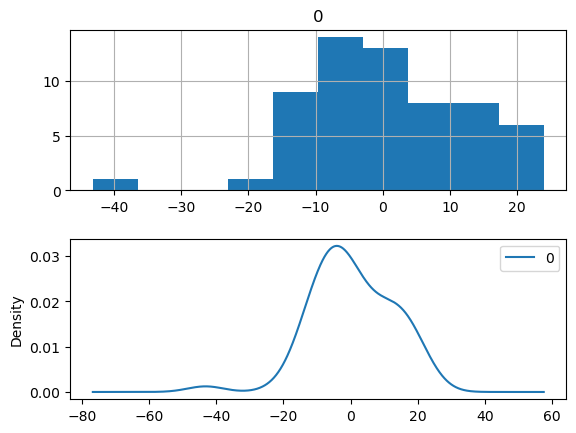

In [107]:
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(12,1,3))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

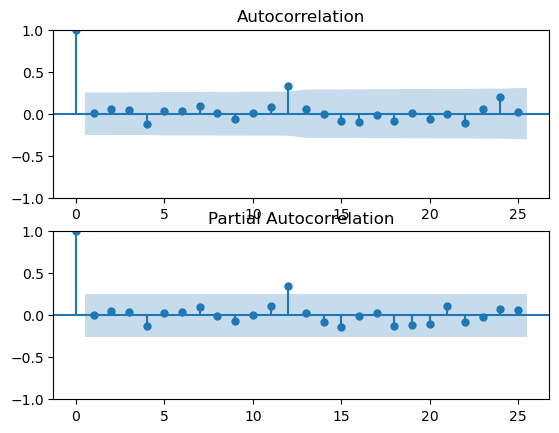

In [95]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, lags=25, ax=pyplot.gca())
pyplot.show()

In [96]:
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
print(evaluate_persistence_model(train, test))

> Predicted=201.000, Expected=204.000
> Predicted=204.000, Expected=188.000
> Predicted=188.000, Expected=235.000
> Predicted=235.000, Expected=227.000
> Predicted=227.000, Expected=234.000
> Predicted=234.000, Expected=264.000
> Predicted=264.000, Expected=302.000
> Predicted=302.000, Expected=293.000
> Predicted=293.000, Expected=259.000
> Predicted=259.000, Expected=229.000
> Predicted=229.000, Expected=203.000
> Predicted=203.000, Expected=229.000
> Predicted=229.000, Expected=242.000
> Predicted=242.000, Expected=233.000
> Predicted=233.000, Expected=267.000
> Predicted=267.000, Expected=269.000
> Predicted=269.000, Expected=270.000
> Predicted=270.000, Expected=315.000
> Predicted=315.000, Expected=364.000
> Predicted=364.000, Expected=347.000
> Predicted=347.000, Expected=312.000
> Predicted=312.000, Expected=274.000
> Predicted=274.000, Expected=237.000
> Predicted=237.000, Expected=278.000
> Predicted=278.000, Expected=284.000
> Predicted=284.000, Expected=277.000
> Predicted=

# Box-Cox Transformed Dataset

The Box-Cox transform is a method that is able to evaluate a suite of power transforms,
including, but not limited to, log, square root, and reciprocal transforms of the data. The
example below performs a log transform of the data and generates some plots to review the
effect on the time series.

Lambda: 0.084293


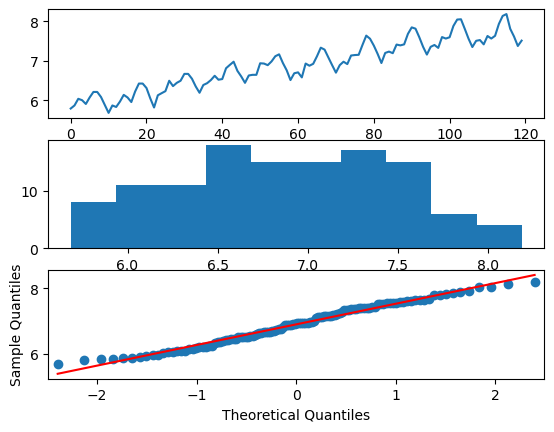

In [97]:
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

In [98]:
# invert Box-Cox transform
from math import log
from math import exp
def boxcox_inverse(value, lam):
 if lam == 0:
  return exp(value)
 return exp(log(lam * value + 1) /lam)

In [102]:
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    # predict
    model = ARIMA(transformed, order=best_cfg)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=212.767, Expected=204.000
>Predicted=208.138, Expected=188.000
>Predicted=223.239, Expected=235.000
>Predicted=235.925, Expected=227.000
>Predicted=230.012, Expected=234.000
>Predicted=245.216, Expected=264.000
>Predicted=274.407, Expected=302.000
>Predicted=304.043, Expected=293.000
>Predicted=261.875, Expected=259.000
>Predicted=225.279, Expected=229.000
>Predicted=197.991, Expected=203.000
>Predicted=222.273, Expected=229.000
>Predicted=226.527, Expected=242.000
>Predicted=220.242, Expected=233.000
>Predicted=267.472, Expected=267.000
>Predicted=263.987, Expected=269.000
>Predicted=269.358, Expected=270.000
>Predicted=303.962, Expected=315.000
>Predicted=348.455, Expected=364.000
>Predicted=346.545, Expected=347.000
>Predicted=308.008, Expected=312.000
>Predicted=274.329, Expected=274.000
>Predicted=245.222, Expected=237.000
>Predicted=265.083, Expected=278.000
>Predicted=290.029, Expected=284.000
>Predicted=274.484, Expected=277.000
>Predicted=304.781, Expected=317.000
>

# Model Validation

## Finalize Model

In [103]:
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import numpy
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()
# prepare data
X = series.values
X = X.astype('float32')
# transform data
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=best_cfg)
model_fit = model.fit()
# save model
model_fit.save('model.pkl')
numpy.save('model_lambda.npy', [lam])

##  Make Prediction

A natural case may be to load the model and make a single forecast. This is relatively straight-
forward and involves restoring the saved model and the lambda and calling the forecast()

function. The example below loads the model, makes a prediction for the next time step, inverses
the Box-Cox transform, and prints the prediction.

In [104]:
from statsmodels.tsa.arima.model import ARIMAResults
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat,lam)
print('Predicted: %.3f' % yhat)

Predicted: 344.259


## Validate Model

[360. 342. 406. 396. 420. 472. 548. 559. 463. 407. 362. 405. 417. 391.
 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]
>Predicted=344.259, Expected=360.000
>Predicted=327.912, Expected=342.000
>Predicted=381.025, Expected=406.000
>Predicted=384.460, Expected=396.000
>Predicted=407.968, Expected=420.000
>Predicted=489.410, Expected=472.000
>Predicted=529.314, Expected=548.000
>Predicted=548.597, Expected=559.000
>Predicted=456.008, Expected=463.000
>Predicted=408.666, Expected=407.000
>Predicted=352.739, Expected=362.000
>Predicted=388.199, Expected=405.000
>Predicted=422.814, Expected=417.000
>Predicted=400.509, Expected=391.000
>Predicted=446.445, Expected=419.000
>Predicted=422.822, Expected=461.000
>Predicted=479.155, Expected=472.000
>Predicted=537.257, Expected=535.000
>Predicted=608.886, Expected=622.000
>Predicted=618.675, Expected=606.000
>Predicted=522.161, Expected=508.000
>Predicted=441.153, Expected=461.000
>Predicted=415.650, Expected=390.000
>Predicted=437.183, Expect

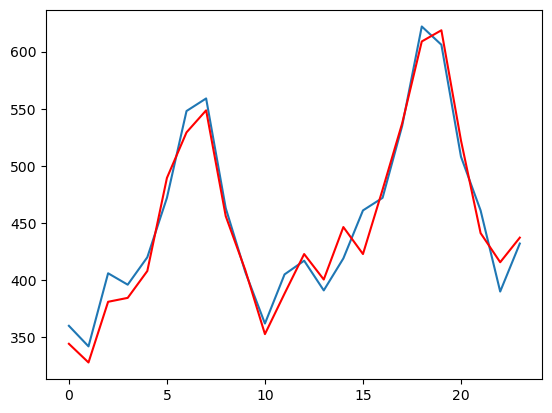

In [105]:
# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True).squeeze()

y = validation.values.astype('float32')
print(y)
# load model
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # transform
    transformed,lam = boxcox(history)
    # predict
    model = ARIMA(transformed, order=best_cfg)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat,lam)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y,predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()